In [1]:
import numpy as np
import torch
from scipy.integrate import odeint
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from torch import nn, autograd
import random

In [2]:
    def duffing_generator_batch( num_batches, x):
        params_list = []  # To store parameters tensors for each batch
        y_physics_list = []  # To store the y_physics tensors for each batch

        for _ in range(num_batches):
            # Randomly generate parameters
            a = random.uniform(-2, 2)
            b = random.uniform(0, 3)
            d = random.uniform(0, 0.5)
            gamma = random.uniform(0, 1.5)
            w = random.uniform(0, 2.5)

            # Duffing differential equation solver setup
            def duffing(y, t):
                y0, y1 = y
                dydt = [y1, -d * y1 - a * y0 - b * y0**3 + gamma * np.cos(w * t)]
                return dydt

            # Initial conditions and solving the ODE
            y0 = [0, 0]
            sol = odeint(duffing, y0, x.cpu().squeeze().numpy())  # Ensure x is compatible with odeint
            y = torch.tensor(sol[:, 0], dtype=torch.float32).view(-1, 1)  # y_physics for one batch

            y_physics_list.append(y)

            # Handling parameters similarly if needed
            params = torch.tensor([d, a, b, gamma, w], dtype=torch.float32).view(1, -1).repeat(x.size(0), 1)
            params_list.append(params)
    
           # params_tensor = torch.tensor(params_list)
            #y_tensor = torch.tensor(y_physics_list)
        # Option 1: Return lists directly
        #return params_tensor, y_tensor

            # Option 2: Stack tensors to create a batch dimension explicitly
            params_tensor = torch.stack(params_list, dim=0)  # Shape: [num_batches, x.size(0), 5]
            y_physics_tensor = torch.stack(y_physics_list, dim=0)  # Shape: [num_batches, x.size(0), 1]
    
            return params_tensor, y_physics_tensor

In [3]:
class AdaptedFCN(nn.Module):
    def __init__(self, n_time_features, n_param_features, n_hidden, n_layers):
        super(AdaptedFCN, self).__init__()
        
        # Number of input features is the sum of time features and parameter features
        self.input_features = n_time_features + n_param_features
        
        # Input layer takes combined time and parameters
        self.input_layer = nn.Linear(self.input_features, n_hidden)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.hidden_layers.append(nn.Linear(n_hidden, n_hidden))
        
        # Output layer
        self.output_layer = nn.Linear(n_hidden, 1)
        
        # Activation function
        self.activation = nn.Tanh()  # Using Tanh as an example; adjust as needed

    def forward(self, x, params):
        # Concatenate time and parameter features
        x_combined = torch.cat((x, params), dim=1)
        
        # Input layer with activation
        x = self.activation(self.input_layer(x_combined))
        
        # Hidden layers with activation
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        
        # Output layer without activation (assuming a regression task)
        x = self.output_layer(x)
        return x

Loss at Step 10 : 3.1820058211451396e-05


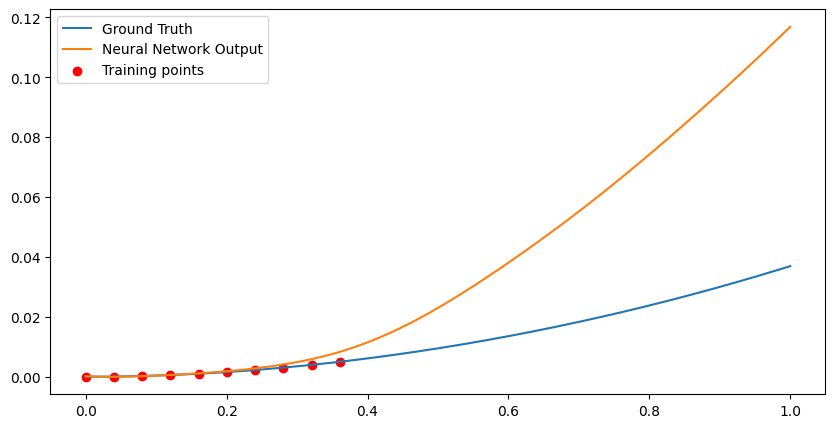

Loss at Step 20 : 6.135688454378396e-05


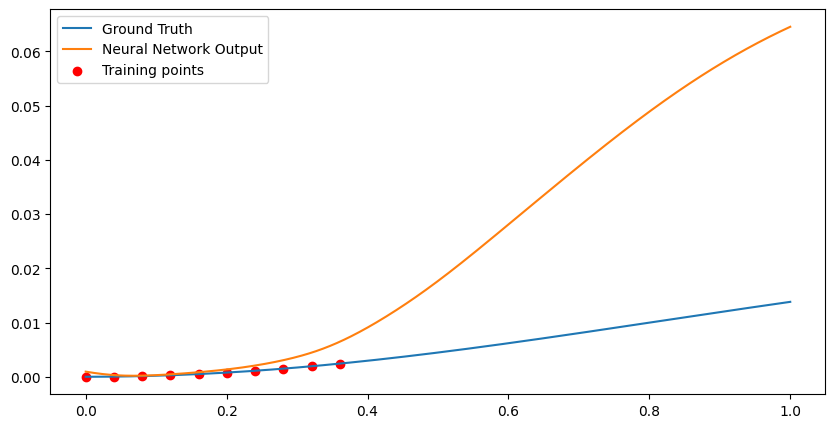

Loss at Step 30 : 9.452500671613961e-05


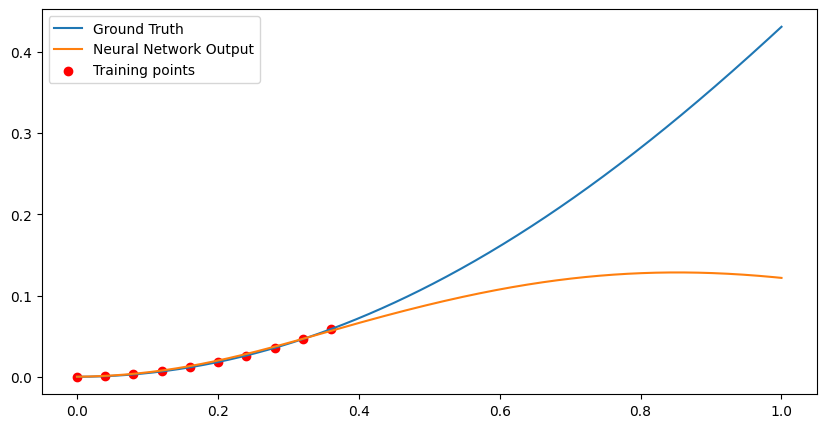

Loss at Step 40 : 2.4546086933696643e-05


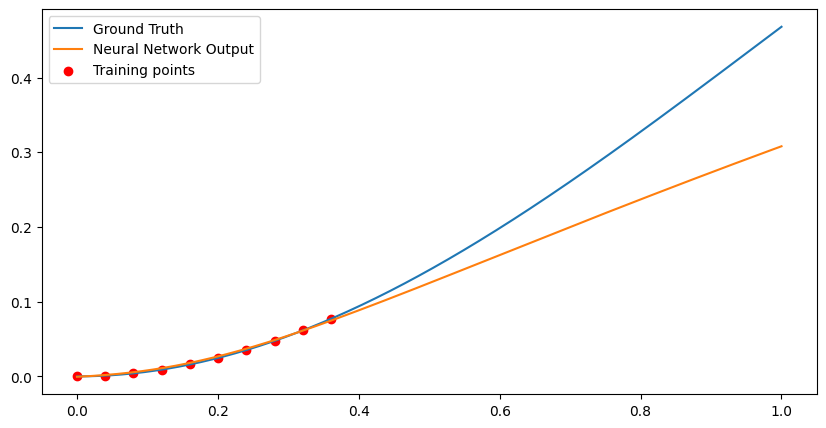

Loss at Step 50 : 1.4492141417576931e-05


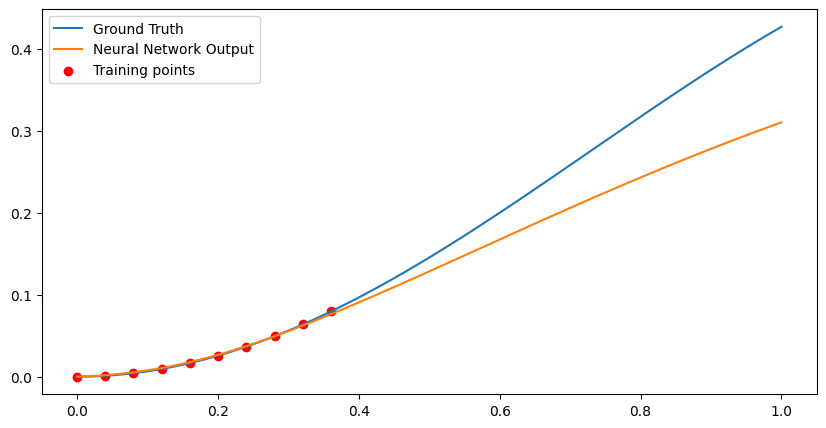

Loss at Step 60 : 3.173359436914325e-05


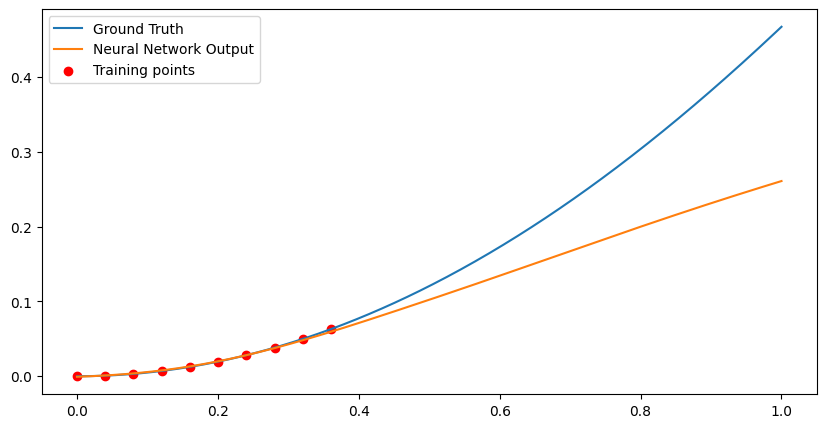

Loss at Step 70 : 1.3108032362652011e-05


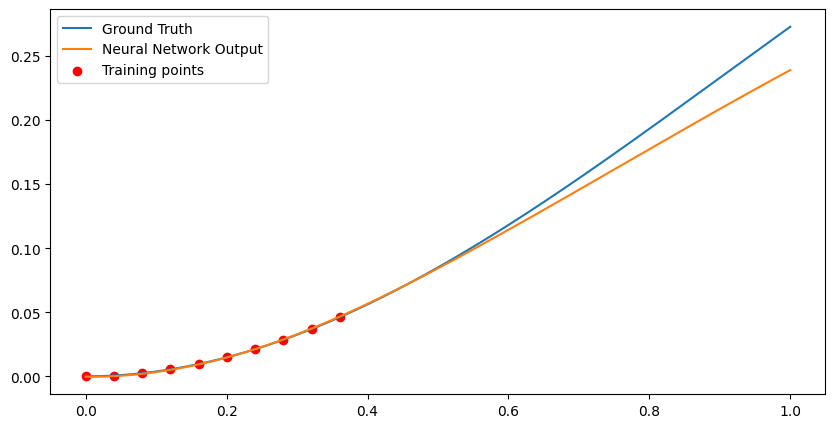

Loss at Step 80 : 5.5978245654841885e-05


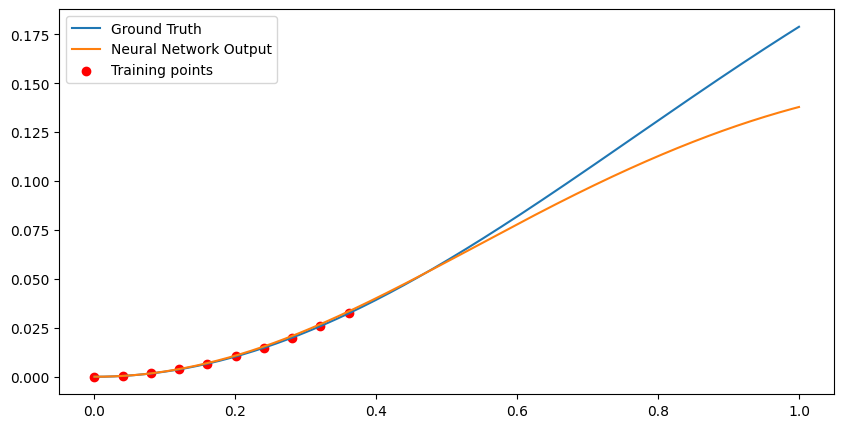

Loss at Step 90 : 4.825292489840649e-05


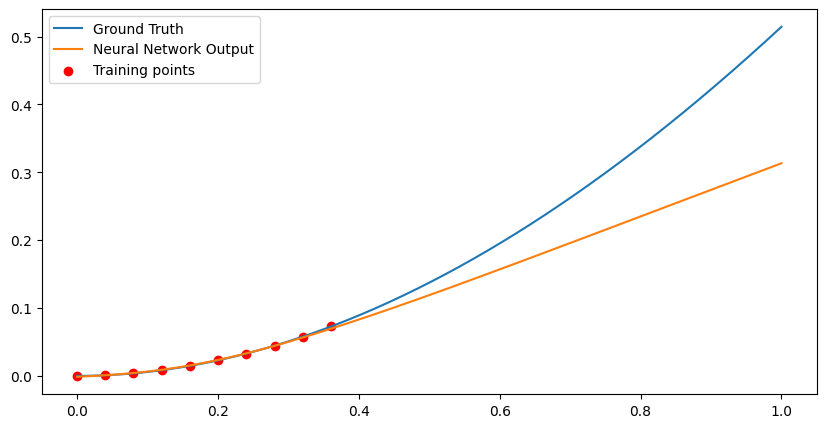

Loss at Step 100 : 2.0800029233214445e-05


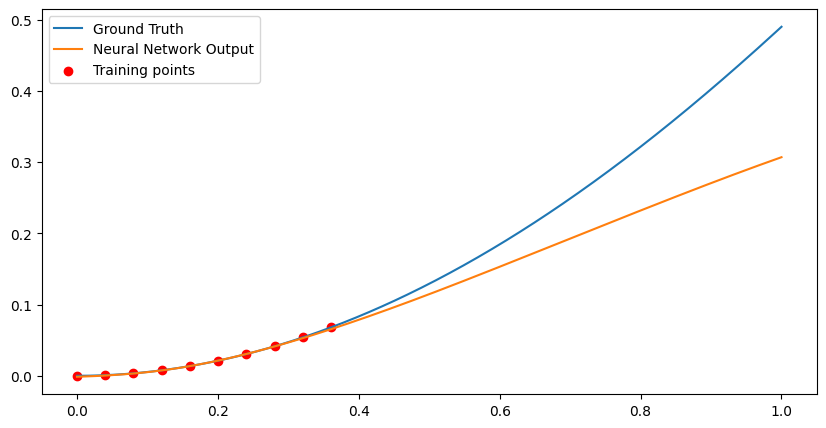

Loss at Step 110 : 9.536722063785419e-05


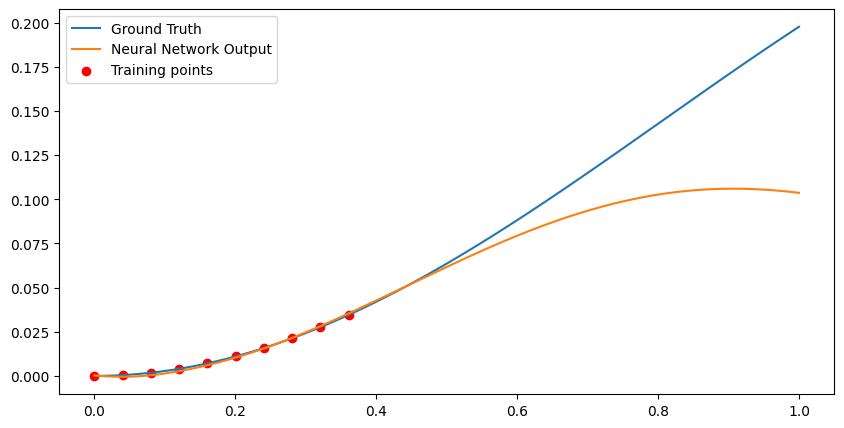

Loss at Step 120 : 1.739936305966694e-05


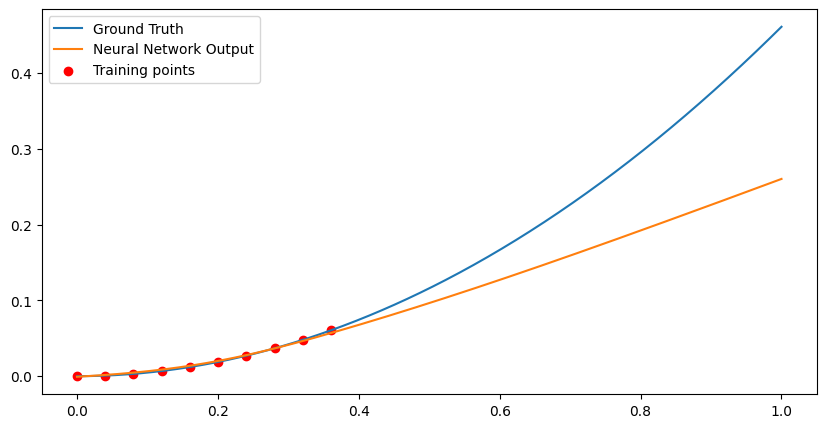

Loss at Step 130 : 8.891036122804508e-05


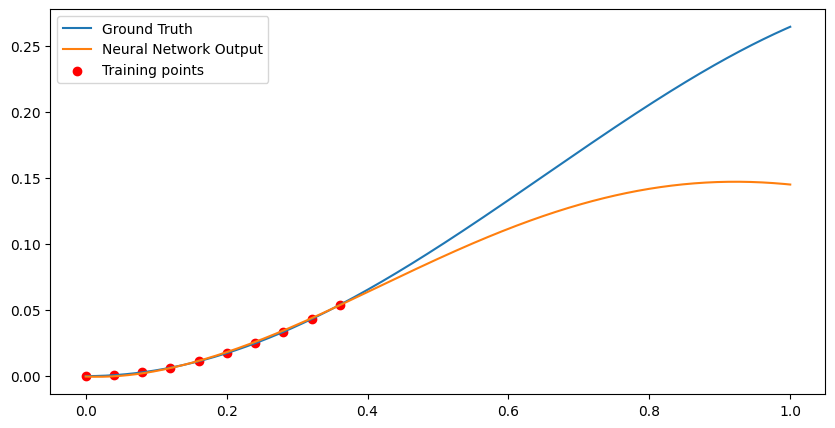

In [ ]:
x = torch.linspace(0, 1, 500).view(-1,1)  
# Set up the physics loss training locations
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
num_batches =10000
# Set up the random seed and initialize the model and optimizer
torch.manual_seed(123)
model = AdaptedFCN(1,5,64,16)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Set up the boundary conditions
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.0  # boundary condition value

# Train the model for 60000 steps
for i in range(6000):
    for batch in range(num_batches):
        optimizer.zero_grad()
        params_tensor,y_tensor= duffing_generator_batch( num_batches, x)
        selected_params = params_tensor[0, :1, :].repeat(x.size(0), 1)  # Adjusted to have shape [500, 5]
        y_data = y_tensor[:, 0:200:20] 
        x_data = x[0:200:20] 
        d, a, b, gamma, w = params_tensor[:, 0], params_tensor[:, 1], params_tensor[:, 2], params_tensor[:, 3], params_tensor[:, 4]
        yh = model(x_data,selected_params[0:200:20])
        
        # Compute the data loss by comparing the model output with the training data
        # Assuming your linear layer is named `layer`
        loss1 = torch.mean((yh - y_data)**2)
        physics_params = params_tensor[0, :1, :].repeat(x_physics.size(0), 1)   
        # Compute the physics loss by enforcing the differential equation
        yhp = model(x_physics,physics_params)
        dy_pred = autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
        d2y_pred = autograd.grad(dy_pred, x_physics, torch.ones_like(dy_pred), create_graph=True)[0]
            
        physics = d2y_pred + d * dy_pred + a * yhp + b * torch.pow(yhp, 3) - gamma * torch.cos(w * x_physics)
        loss_physics = (1e-4) * torch.mean(physics**2)
            
        # Compute the boundary loss by enforcing the boundary conditions
        x_boundary = torch.tensor([X_BOUNDARY]).view(-1, 1).requires_grad_(True)
        f_boundary = torch.tensor([F_BOUNDARY]).view(-1, 1)
        boundary_params = params_tensor[0, :1, :].repeat(x_boundary.size(0), 1) 
        yh_boundary = model(x_boundary,boundary_params)
        boundary = yh_boundary - f_boundary
        loss_boundary = torch.mean(boundary**2)
            
        # Compute the total loss as the sum of the data loss, the physics loss, and the boundary loss
        total_loss = loss1 + loss_physics + loss_boundary
            
        # Update the model parameters using backpropagation and gradient descent
        total_loss.backward()
        optimizer.step()
        y_tensor_squeezed = y_tensor.squeeze()
    # Plot the results every 150 steps
    if (i+1) % 10 == 0:   
        # Print the loss value after each step
        print("Loss at Step", i+1, ":", total_loss.item())
        yh = model(x,selected_params).detach().numpy()
        plt.figure(figsize=(10, 5))
        plt.plot(x.numpy(), y_tensor_squeezed.numpy(), label='Ground Truth')
        plt.plot(x.numpy(), yh, label='Neural Network Output')
        plt.scatter(x_data.numpy(), y_data.numpy(), color='red', label='Training points')
        plt.legend()
        plt.show()